<a href="https://colab.research.google.com/github/malloyca/CSC581B/blob/main/Final%20Project/vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC581B - Introduction to Deep Learning for Image Classification
# Final Project - Linear Classifier

In [77]:
# imports
import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import numpy as np
import random

In [2]:
standard_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
      mean = [0.5071, 0.4867, 0.4408],
      std = [0.2675, 0.2565, 0.2761]
  )
])

In [3]:
# Load the training data (CIFAR10 to start)
training_data = CIFAR100(
    root = "data",
    train = True,
    download = True,
    #transform = data_augmentation_transforms,
    transform = standard_transforms,
)

# this is necessary to prevent the data augmentation transforms from being applied to the validation set
validation_data = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = standard_transforms,
)

# Load the test data
test_data = CIFAR100(
    root = "data",
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


In [4]:
training_targets = training_data.targets

In [5]:
train_split_index, valid_split_index = train_test_split(
    np.arange(len(training_targets)), test_size=0.2, stratify=training_targets
)

In [6]:
batch_size = 100

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size,
                              sampler=SubsetRandomSampler(train_split_index))
valid_dataloader = DataLoader(validation_data, batch_size=batch_size,
                              sampler=SubsetRandomSampler(valid_split_index))
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [7]:
# Check that it is splitting the data properly
train_length = 0
for _, y in train_dataloader:
  train_length += len(y)
print(f"Length of training split: {train_length}")

valid_length = 0
for _, y in valid_dataloader:
  valid_length += len(y)
print(f"Length of validation split: {valid_length}")

test_length = 0
for _, y in test_dataloader:
  test_length += len(y)
print(f"Length of test split: {test_length}")

Length of training split: 40000
Length of validation split: 10000
Length of test split: 10000


In [8]:
# Check that there are 100 instances of a random class in the validation set
count = 0
test_class = random.randint(0,99)
for _, y in valid_dataloader:
  for target in y:
    if int(target.numpy()) == test_class:
      count += 1

print(count)

100


## Building some linear models

In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [58]:
# Define the model
class LinearModel(nn.Module):
  def __init__(self, n_neurons):
    super(LinearModel, self).__init__()
    self.name = f'model_{n_neurons}'
    self.flatten = nn.Flatten()
    self.linear_model = nn.Sequential(
        nn.Linear(32*32*3, n_neurons),
        nn.Linear(n_neurons, n_neurons),
        nn.Linear(n_neurons, 100),
    )

  # Forward propagation function
  def forward(self, x):
    x = self.flatten(x)
    x = self.linear_model(x)
    return x

In [145]:
# Train function
def train(dataloader, batch_size, model, loss_fn, optimizer):
  num_batches = len(dataloader)
  size = num_batches * batch_size
  model.train()
  train_loss, num_correct = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # batch loss / accuracy
    train_loss += loss.item()
    num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

  # Calculate batch loss / accuracy
  train_loss /= num_batches
  accuracy = num_correct / size
  return train_loss, accuracy

In [146]:
# Validation function
def validation(dataloader, batch_size, model, loss_fn):
  num_batches = len(dataloader)
  size = num_batches * batch_size
  model.eval()
  val_loss, num_correct = 0, 0
  
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      val_loss += loss_fn(pred, y).item()
      num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  val_loss /= num_batches
  accuracy = num_correct / size
  print(f"Validation Error: \n Validation accuracy: {(100 * accuracy):>0.1f}%, Validation loss: {val_loss:>8f} \n")
  return val_loss, accuracy

In [147]:
# Test function
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return test_loss

In [148]:
def training_loop(n_epochs, model, train_data, valid_data, batch_size,
                  loss_function, optimizer, scheduler=None,
                  early_stopping=False, patience=10):
  current_epoch = 0
  best_epoch = 0
  best_loss = float('inf')
  patience_counter = 0
  
  # for graph visualization
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []


  for e in range(n_epochs):
    print(f"\nEpoch {e+1}\n----------------------------")
    # Iterate epoch counter
    current_epoch += 1

    train_loss, train_accuracy = train(train_data, batch_size, model, loss_function, optimizer)
    val_loss, val_accuracy = validation(valid_data, batch_size, model, loss_function)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Iterate scheduler (this is set up for ReduceLROnPlateau)
    if scheduler is not None:
      scheduler.step()

    # Add data to TensorBoard
    writer.add_scalar("Val_loss", val_loss, e)

    # If early_stopping check test_loss
    if early_stopping:
      # case: test loss beats the current best loss
      if val_loss < best_loss:
        # store loss
        best_loss = val_loss

        # reset patience counter
        patience_counter = 0

        # store model and epoch number
        print("Storing new best model.")
        best_model_state_dict = copy.deepcopy(model.state_dict)
        best_epoch = current_epoch

      # Case: patience limit not yet reached => iterate patience counter
      elif patience_counter < patience - 1:
        patience_counter += 1
        print(f"Patience count: {patience_counter}")

      # Case: patience limit reached
      else:
        print("Finished due to early stopping.")
        print(f"Saving best model: {model.name}_epoch-{best_epoch:03d}")
        torch.save(best_model_state_dict, f'{model.name}_epoch-{best_epoch:03d}')
        break

  # If we get here, we did not stop early - save best model
  if early_stopping:
    print(f"Saving best model: {model.name}_epoch-{best_epoch:03d}")
    torch.save(best_model_state_dict, f'{model.name}_epoch-{best_epoch:03d}')

  return train_losses, train_accuracies, val_losses, val_accuracies

# Visualizing some images

Shape of an image (batch size, RGB, pixels): torch.Size([100, 3, 32, 32])


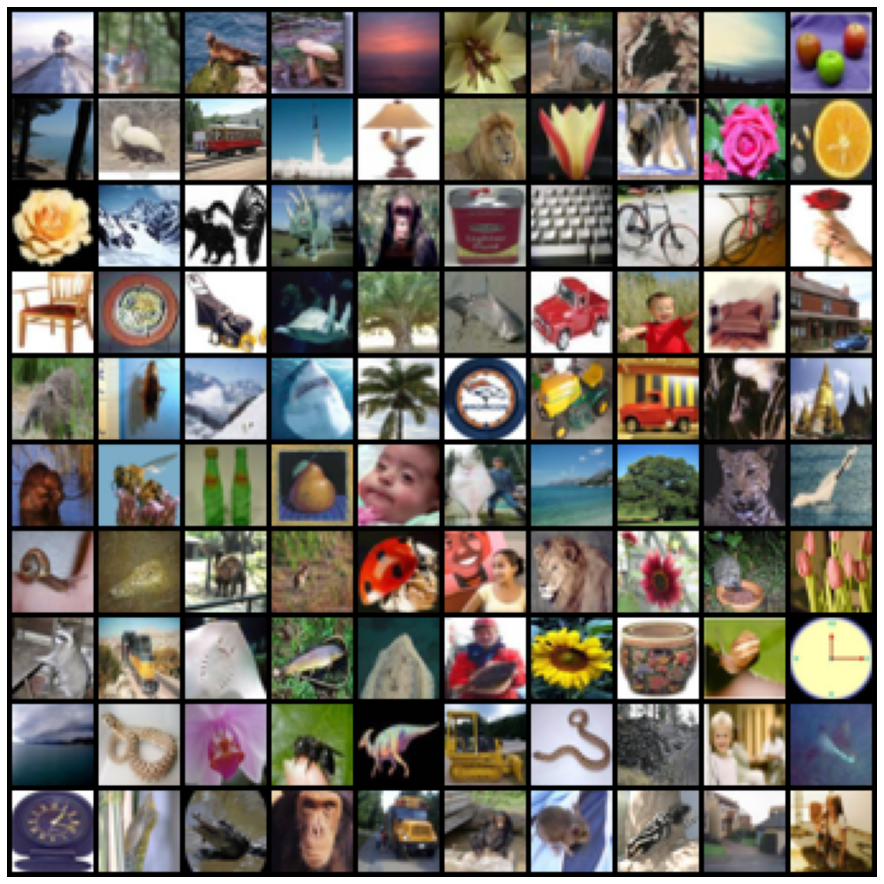

In [90]:
# Doing this on the test dataset since I normalized the train and validation datasets
for images, _ in test_dataloader:
  plt.figure(figsize=(16,16))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=10).permute((1,2,0)))

  break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


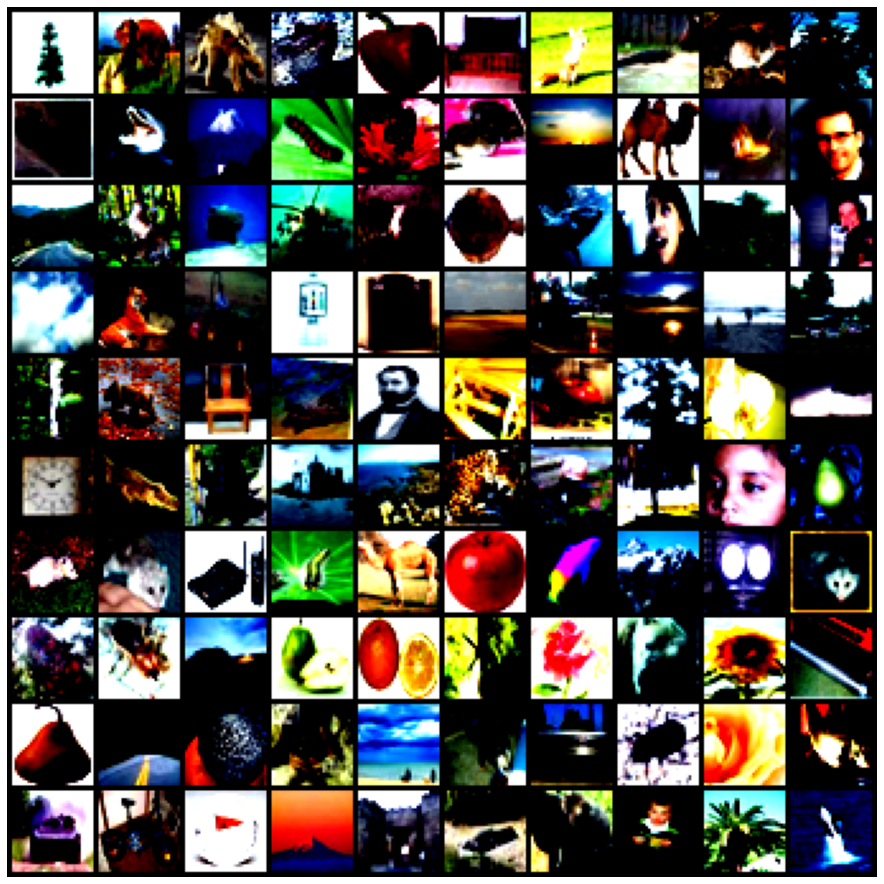

In [92]:
# This is what the normalized training images look like
for images, _ in train_dataloader:
  plt.figure(figsize=(16,16))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=10).permute((1,2,0)))

  break

# Training

In [149]:
n_epochs = 5

In [150]:
model_100 = LinearModel(n_neurons=100).to(device)
#print(model_100)

model_500 = LinearModel(n_neurons=500).to(device)
#print(model_500)

model_1000 = LinearModel(n_neurons=1000).to(device)
#print(model_1000)

model_2000 = LinearModel(n_neurons=2000).to(device)
#print(model_2000)

model_5000 = LinearModel(n_neurons=5000).to(device)
print(model_5000)

LinearModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_model): Sequential(
    (0): Linear(in_features=3072, out_features=5000, bias=True)
    (1): Linear(in_features=5000, out_features=5000, bias=True)
    (2): Linear(in_features=5000, out_features=100, bias=True)
  )
)


In [151]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer_100 = torch.optim.SGD(model_100.parameters(), lr=1e-1)
optimizer_500 = torch.optim.SGD(model_500.parameters(), lr=1e-1)
optimizer_1000 = torch.optim.SGD(model_1000.parameters(), lr=1e-1)
optimizer_2000 = torch.optim.SGD(model_2000.parameters(), lr=1e-1)
optimizer_5000 = torch.optim.SGD(model_5000.parameters(), lr=1e-1)

# Learning rate schedulers
scheduler_100 = StepLR(optimizer_100, step_size=5, gamma=0.1)
scheduler_500 = StepLR(optimizer_500, step_size=5, gamma=0.1)
scheduler_1000 = StepLR(optimizer_1000, step_size=5, gamma=0.1)
scheduler_2000 = StepLR(optimizer_2000, step_size=5, gamma=0.1)
scheduler_5000 = StepLR(optimizer_5000, step_size=5, gamma=0.1)

In [152]:
train_losses, train_accuracies, val_losses, val_accuracies = training_loop(n_epochs, model_100, train_dataloader, valid_dataloader, batch_size,
              loss_fn, optimizer_100, scheduler_100)


Epoch 1
----------------------------
loss: 4.591752 [    0/40000]
loss: 3.808723 [10000/40000]
loss: 3.778436 [20000/40000]
loss: 3.977998 [30000/40000]
Validation Error: 
 Validation accuracy: 14.4%, Validation loss: 3.796691 


Epoch 2
----------------------------
loss: 3.886372 [    0/40000]
loss: 3.734725 [10000/40000]
loss: 4.022091 [20000/40000]
loss: 3.936542 [30000/40000]
Validation Error: 
 Validation accuracy: 15.1%, Validation loss: 3.713326 


Epoch 3
----------------------------
loss: 3.757815 [    0/40000]
loss: 3.532570 [10000/40000]
loss: 3.603842 [20000/40000]
loss: 3.660615 [30000/40000]
Validation Error: 
 Validation accuracy: 16.0%, Validation loss: 3.715476 


Epoch 4
----------------------------
loss: 3.573007 [    0/40000]
loss: 3.681531 [10000/40000]
loss: 3.556787 [20000/40000]
loss: 3.718838 [30000/40000]
Validation Error: 
 Validation accuracy: 16.7%, Validation loss: 3.671672 


Epoch 5
----------------------------
loss: 3.452929 [    0/40000]
loss: 3.23522

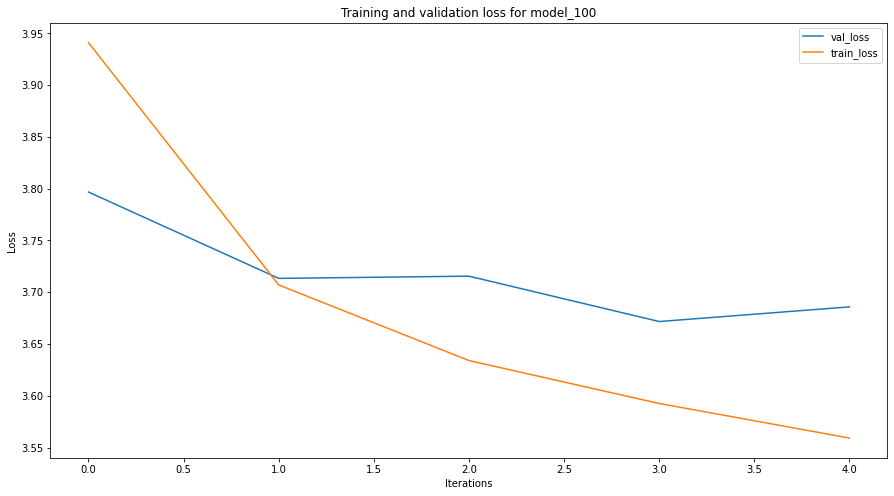

In [153]:
plt.figure(figsize=(15,8))
plt.title(f"Training and validation loss for {model_100.name}")
plt.plot(val_losses, label="val_loss")
plt.plot(train_losses, label="train_loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

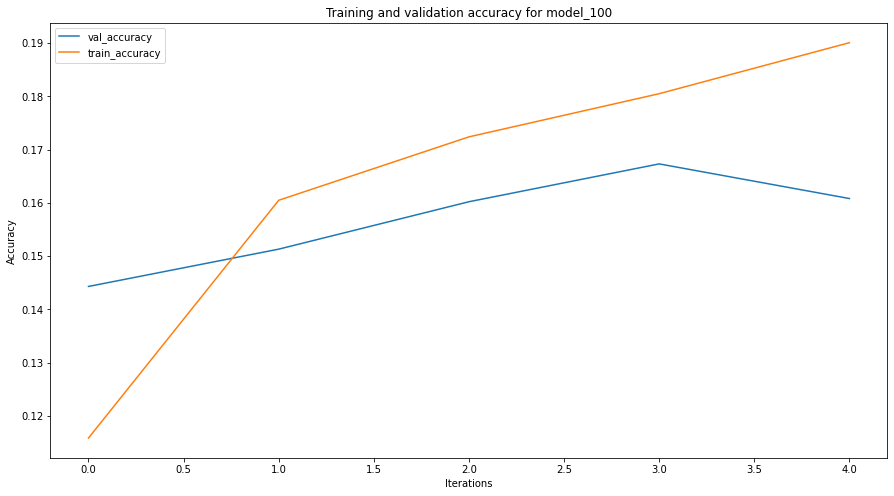

In [155]:
plt.figure(figsize=(15,8))
plt.title(f"Training and validation accuracy for {model_100.name}")
plt.plot(val_accuracies, label="val_accuracy")
plt.plot(train_accuracies, label="train_accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [137]:
train_losses, train_accuracies, val_losses, val_accuracies = training_loop(n_epochs, model_500, train_dataloader, valid_dataloader, batch_size,
              loss_fn, optimizer_500, scheduler_500)


Epoch 1
----------------------------
loss: 4.611555 [    0/40000]
loss: 3.680940 [10000/40000]
loss: 3.698388 [20000/40000]
loss: 3.999506 [30000/40000]
Validation Error: 
 Validation accuracy: 14.3%, Validation loss: 3.771072 


Epoch 2
----------------------------
loss: 3.504407 [    0/40000]
loss: 3.805985 [10000/40000]
loss: 3.517563 [20000/40000]
loss: 3.561516 [30000/40000]
Validation Error: 
 Validation accuracy: 16.2%, Validation loss: 3.705696 


Epoch 3
----------------------------
loss: 3.460289 [    0/40000]
loss: 3.268473 [10000/40000]
loss: 3.560499 [20000/40000]
loss: 3.643891 [30000/40000]
Validation Error: 
 Validation accuracy: 16.6%, Validation loss: 3.685224 


Epoch 4
----------------------------
loss: 3.427697 [    0/40000]
loss: 3.495101 [10000/40000]
loss: 3.535823 [20000/40000]
loss: 3.776077 [30000/40000]
Validation Error: 
 Validation accuracy: 16.2%, Validation loss: 3.703223 


Epoch 5
----------------------------
loss: 3.351374 [    0/40000]
loss: 3.46954

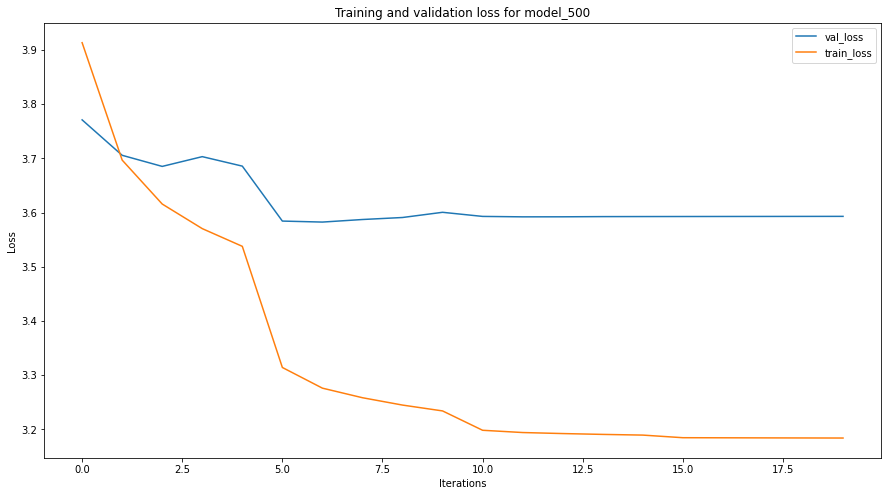

In [138]:
plt.figure(figsize=(15,8))
plt.title(f"Training and validation loss for {model_500.name}")
plt.plot(val_losses, label="val_loss")
plt.plot(train_losses, label="train_loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Training and validation accuracy for {model_500.name}")
plt.plot(val_accuracies, label="val_accuracy")
plt.plot(train_accuracies, label="train_accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [139]:
train_losses, val_losses = training_loop(n_epochs, model_1000, train_dataloader, valid_dataloader, batch_size,
              loss_fn, optimizer_1000, scheduler_1000)


Epoch 1
----------------------------
loss: 4.575779 [    0/40000]
loss: 4.167337 [10000/40000]
loss: 3.845329 [20000/40000]
loss: 3.729959 [30000/40000]
Validation Error: 
 Validation accuracy: 15.1%, Validation loss: 3.790382 


Epoch 2
----------------------------
loss: 3.700651 [    0/40000]
loss: 3.411746 [10000/40000]
loss: 3.723169 [20000/40000]
loss: 3.673166 [30000/40000]
Validation Error: 
 Validation accuracy: 16.4%, Validation loss: 3.692732 


Epoch 3
----------------------------
loss: 3.734512 [    0/40000]
loss: 3.505176 [10000/40000]
loss: 3.749699 [20000/40000]
loss: 3.728925 [30000/40000]
Validation Error: 
 Validation accuracy: 14.9%, Validation loss: 3.760997 


Epoch 4
----------------------------
loss: 3.359228 [    0/40000]
loss: 3.545969 [10000/40000]
loss: 3.495364 [20000/40000]
loss: 3.759597 [30000/40000]
Validation Error: 
 Validation accuracy: 15.1%, Validation loss: 3.728219 


Epoch 5
----------------------------
loss: 3.256405 [    0/40000]
loss: 3.63340

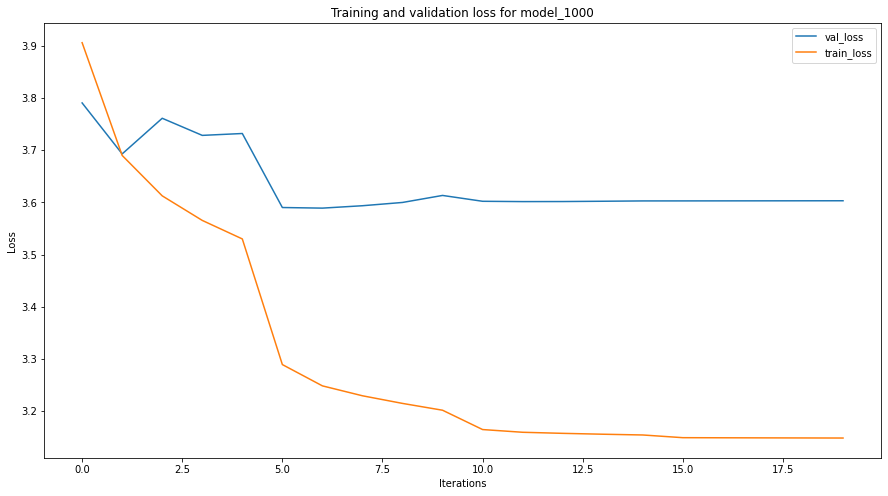

In [140]:
plt.figure(figsize=(15,8))
plt.title(f"Training and validation loss for {model_1000.name}")
plt.plot(val_losses, label="val_loss")
plt.plot(train_losses, label="train_loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Training and validation accuracy for {model_1000.name}")
plt.plot(val_accuracies, label="val_accuracy")
plt.plot(train_accuracies, label="train_accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [141]:
train_losses, val_losses = training_loop(n_epochs, model_2000, train_dataloader, valid_dataloader, batch_size,
              loss_fn, optimizer_2000, scheduler_2000)


Epoch 1
----------------------------
loss: 4.632493 [    0/40000]
loss: 3.856433 [10000/40000]
loss: 3.818379 [20000/40000]
loss: 3.743084 [30000/40000]
Validation Error: 
 Validation accuracy: 15.0%, Validation loss: 3.765220 


Epoch 2
----------------------------
loss: 3.677220 [    0/40000]
loss: 3.478209 [10000/40000]
loss: 3.604943 [20000/40000]
loss: 3.603768 [30000/40000]
Validation Error: 
 Validation accuracy: 15.8%, Validation loss: 3.734430 


Epoch 3
----------------------------
loss: 3.360242 [    0/40000]
loss: 3.446948 [10000/40000]
loss: 3.682532 [20000/40000]
loss: 3.713772 [30000/40000]
Validation Error: 
 Validation accuracy: 15.5%, Validation loss: 3.744463 


Epoch 4
----------------------------
loss: 3.540446 [    0/40000]
loss: 3.521860 [10000/40000]
loss: 3.389922 [20000/40000]
loss: 3.656914 [30000/40000]
Validation Error: 
 Validation accuracy: 15.7%, Validation loss: 3.737977 


Epoch 5
----------------------------
loss: 3.294471 [    0/40000]
loss: 3.57979

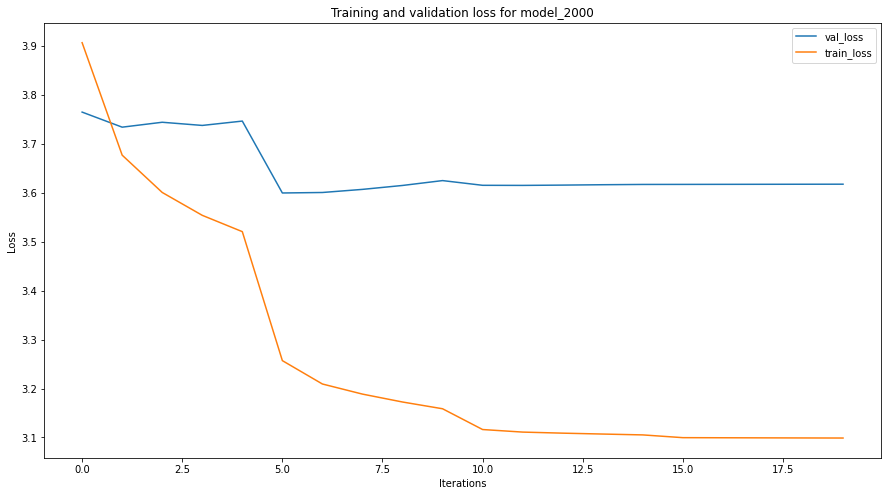

In [142]:
plt.figure(figsize=(15,8))
plt.title(f"Training and validation loss for {model_2000.name}")
plt.plot(val_losses, label="val_loss")
plt.plot(train_losses, label="train_loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Training and validation accuracy for {model_2000.name}")
plt.plot(val_accuracies, label="val_accuracy")
plt.plot(train_accuracies, label="train_accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [143]:
train_losses, val_losses = training_loop(n_epochs, model_5000, train_dataloader, valid_dataloader, batch_size,
              loss_fn, optimizer_5000, scheduler_5000)


Epoch 1
----------------------------
loss: 4.651811 [    0/40000]
loss: 3.974017 [10000/40000]
loss: 3.781010 [20000/40000]
loss: 3.866777 [30000/40000]
Validation Error: 
 Validation accuracy: 15.3%, Validation loss: 3.757314 


Epoch 2
----------------------------
loss: 3.620521 [    0/40000]
loss: 3.725902 [10000/40000]
loss: 3.466767 [20000/40000]
loss: 3.420674 [30000/40000]
Validation Error: 
 Validation accuracy: 14.6%, Validation loss: 3.779338 


Epoch 3
----------------------------
loss: 3.379357 [    0/40000]
loss: 3.601773 [10000/40000]
loss: 3.620271 [20000/40000]
loss: 3.619171 [30000/40000]
Validation Error: 
 Validation accuracy: 16.3%, Validation loss: 3.728306 


Epoch 4
----------------------------
loss: 3.527497 [    0/40000]
loss: 3.453513 [10000/40000]
loss: 3.695381 [20000/40000]
loss: 3.887599 [30000/40000]
Validation Error: 
 Validation accuracy: 15.7%, Validation loss: 3.752594 


Epoch 5
----------------------------
loss: 3.260475 [    0/40000]
loss: 3.44641

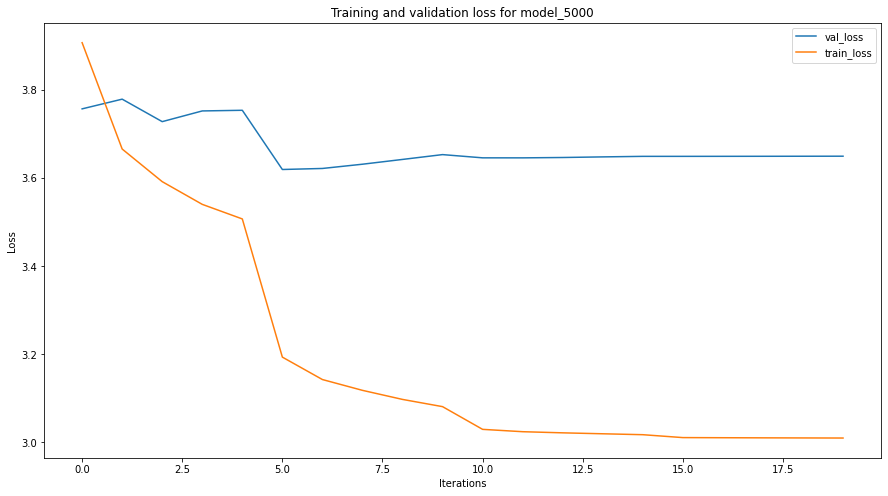

In [144]:
plt.figure(figsize=(15,8))
plt.title(f"Training and validation loss for {model_5000.name}")
plt.plot(val_losses, label="val_loss")
plt.plot(train_losses, label="train_loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Training and validation accuracy for {model_5000.name}")
plt.plot(val_accuracies, label="val_accuracy")
plt.plot(train_accuracies, label="train_accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()